<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/5.%20Modelling/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning imports from scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, make_scorer
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Other necessary libraries
from scipy.stats import mstats
from tqdm import tqdm
import copy

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 240)

In [26]:
!wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/clean_data.csv' -O clean_data.csv

data = pd.read_csv('clean_data.csv')
data.shape

--2024-05-09 11:08:47--  https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/clean_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175178 (171K) [text/plain]
Saving to: ‘clean_data.csv’

clean_data.csv      100%[===================>] 171.07K  --.-KB/s    in 0.01s   

2024-05-09 11:08:47 (12.5 MB/s) - ‘clean_data.csv’ saved [175178/175178]



(780, 52)

In [27]:
# Plotting Function
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 2.5))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# Scorer Functions
def sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    return sensitivity

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    return specificity

def auroc_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def aucpr_scorer(y_true, y_pred):
    return average_precision_score(y_true, y_pred)

sensitivity_scorer = make_scorer(sensitivity)
specificity_scorer = make_scorer(specificity)
auroc_scorer = make_scorer(auroc_scorer)
aucpr_scorer = make_scorer(aucpr_scorer)

# Winsorization Class
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, lower=0.01, upper=0.99):
        self.columns = columns
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        # Keine spezielle Anpassung erforderlich
        return self

    def transform(self, X):
        if self.columns is None:
            columns = X.columns
        else:
            columns = self.columns

        X_copy = X.copy()
        for col in columns:
            X_copy[col] = mstats.winsorize(X_copy[col], limits=[self.lower, self.upper])

        return X_copy

In [28]:
# Results storage for confusion matrices, classification reports, and ROC curves
models = []
accuracy = []
accuracy_sd = []
sensitivity_list = []
sensitivity_sd = []
specificity_list = []
specificity_sd = []
auroc = []
auroc_sd = []
aucpr = []
aucpr_sd = []

confusion_matrices = []
roc_curves = []

In [29]:
# Defining Feature Sets
'''
extreme_outlier = [
    "BMI",
    "Body_Temperature"
]
'''

restricted = [
    "Length_of_Stay",
    "Appendix_on_US",
    "Alvarado_Score",
    "Paedriatic_Appendicitis_Score",
    "Segmented_Neutrophils"
]


partially_restricted = [
    "Length_of_Stay",
    "Neutrophilia",
    "CRP",
    "Alvarado_Score",
    "Ketones_in_Urine",
    "WBC_in_Urine",
    "RBC_in_Urine",
    "Paedriatic_Appendicitis_Score"
]

unrestricted = [
    'Appendix_Diameter',
    'Length_of_Stay',
    'Surrounding_Tissue_Reaction',
    'Alvarado_Score',
    'Neutrophil_Percentage',
    'Appendix_on_US',
    'CRP',
    'Peritonitis',
    'WBC_Count'
]

complete = ['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW',
       'Thrombocyte_Count', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign',
       'Appendicolith', 'Perfusion', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Pathological_Lymph_Nodes', 'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism',
       'Enteritis', 'Gynecological_Findings']

target = "Diagnosis"

sets = [restricted, partially_restricted, unrestricted, complete]
set_names = [
    "Restricted Dataset: Demographic + Scoring + Clinical",
    "Partially Restricted Dataset: Demographic + Scoring + Clinical + Laboratory",
    "Unrestricted Dataset: Demographic + Scoring + Clinical + Laboratory + Ultrasound",
    "Complete Dataset: all variables"
            ]

In [30]:
# sets = {
#     "Restricted Dataset: Demographic + Scoring + Clinical": restricted,
#     "Partially Restricted Dataset: Demographic + Scoring + Clinical + Laboratory": partially_restricted,
#     "Unrestricted Dataset: Demographic + Scoring + Clinical + Laboratory + Ultrasound": unrestricted,
#     "Complete Dataset: all variables": complete
# }

In [31]:
for i,j in enumerate(sets):
    print(i)
    print(j)

0
['Length_of_Stay', 'Appendix_on_US', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Segmented_Neutrophils']
1
['Length_of_Stay', 'Neutrophilia', 'CRP', 'Alvarado_Score', 'Ketones_in_Urine', 'WBC_in_Urine', 'RBC_in_Urine', 'Paedriatic_Appendicitis_Score']
2
['Appendix_Diameter', 'Length_of_Stay', 'Surrounding_Tissue_Reaction', 'Alvarado_Score', 'Neutrophil_Percentage', 'Appendix_on_US', 'CRP', 'Peritonitis', 'WBC_Count']
3
['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain', 'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tendernes

In [32]:
# sets["Restricted Dataset: Demographic + Scoring + Clinical"]

## Logistic Regression

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.827 (± 0.04 )
ROC: 	 	 0.816 (± 0.05 )
AUCPR: 	 	 0.809 (± 0.04 )
Sensitivy: 	 0.880 (± 0.04 )
Specificity: 	 0.752 (± 0.00 )
 


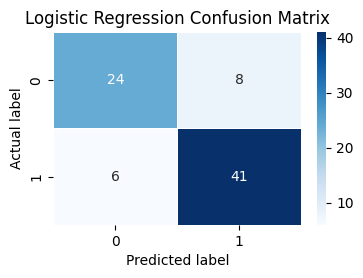

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.732 (± 0.03 )
ROC: 	 	 0.721 (± 0.04 )
AUCPR: 	 	 0.735 (± 0.03 )
Sensitivy: 	 0.771 (± 0.05 )
Specificity: 	 0.671 (± 0.00 )
 


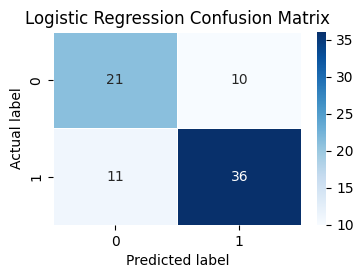

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.885 (± 0.03 )
ROC: 	 	 0.884 (± 0.03 )
AUCPR: 	 	 0.882 (± 0.03 )
Sensitivy: 	 0.884 (± 0.04 )
Specificity: 	 0.884 (± 0.00 )
 


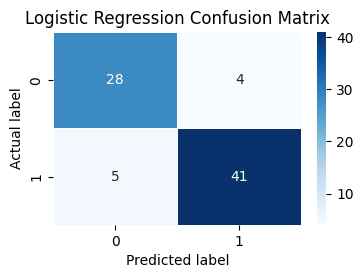

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.874 (± 0.03 )
ROC: 	 	 0.869 (± 0.03 )
AUCPR: 	 	 0.864 (± 0.03 )
Sensitivy: 	 0.889 (± 0.04 )
Specificity: 	 0.849 (± 0.00 )
 


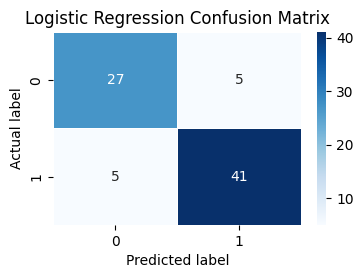

In [33]:
for index, features in enumerate(sets):
    X = data[features]
    y = data[target]

    # Model & pipeline
    lr_model = LogisticRegression(max_iter=1000, random_state=123)

    lr_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('classifier', lr_model)
    ])

    models.append('Logistic Regression')

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores: Confusion Matrix
    y_pred_cv = cross_val_predict(lr_pipeline, X, y, cv=k_fold)
    cm_lr = confusion_matrix(y, y_pred_cv)
    cm_lr = cm_lr / splits
    cm_lr = np.round(cm_lr,0)
    cm_lr = cm_lr.astype(int)
    confusion_matrices.append(cm_lr)

    # Accuracy
    cv_scores_accuracy = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    accuracy.append(mean_cv_accuracy)
    accuracy_sd.append(sd_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    auroc.append(mean_cv_auroc)
    auroc_sd.append(sd_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    aucpr.append(mean_cv_aucpr)
    aucpr_sd.append(sd_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    sensitivity_list.append(mean_cv_sensitivity)
    sensitivity_sd.append(sd_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(lr_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    specificity_list.append(mean_cv_specificity)
    specificity_sd.append(sd_cv_specificity)

    print("++++++++++10-fold CV:++++++++++")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_lr, "Logistic Regression Confusion Matrix")

## Naive Bayes Classifier

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.790 (± 0.03 )
ROC: 	 	 0.797 (± 0.03 )
AUCPR: 	 	 0.807 (± 0.03 )
Sensitivy: 	 0.754 (± 0.05 )
Specificity: 	 0.840 (± 0.00 )
 


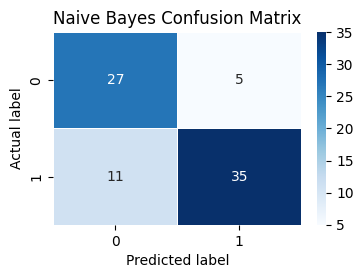

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.704 (± 0.05 )
ROC: 	 	 0.719 (± 0.04 )
AUCPR: 	 	 0.743 (± 0.04 )
Sensitivy: 	 0.635 (± 0.06 )
Specificity: 	 0.802 (± 0.00 )
 


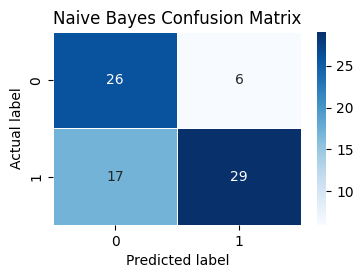

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.794 (± 0.06 )
ROC: 	 	 0.807 (± 0.06 )
AUCPR: 	 	 0.825 (± 0.05 )
Sensitivy: 	 0.729 (± 0.05 )
Specificity: 	 0.886 (± 0.00 )
 


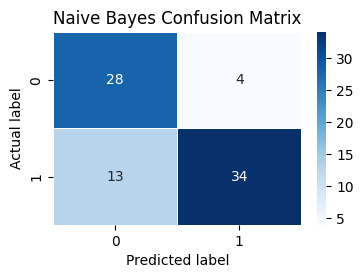

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.636 (± 0.04 )
ROC: 	 	 0.687 (± 0.03 )
AUCPR: 	 	 0.738 (± 0.03 )
Sensitivy: 	 0.410 (± 0.07 )
Specificity: 	 0.965 (± 0.00 )
 


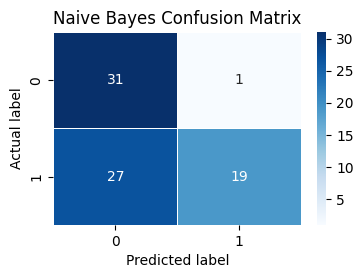

In [34]:
for index, features in enumerate(sets):
    X = data[features]
    y = data[target]

    # Model & pipeline
    nb_model = GaussianNB()

    nb_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('classifier', nb_model)
    ])

    models.append('Naive Bayes')

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores: Confusion Matrix
    y_pred_cv = cross_val_predict(nb_pipeline, X, y, cv=k_fold)
    cm_nb = confusion_matrix(y, y_pred_cv)
    cm_nb = cm_nb / splits
    cm_nb = np.round(cm_nb,0)
    cm_nb = cm_nb.astype(int)
    confusion_matrices.append(cm_nb)

    # Accuracy
    cv_scores_accuracy = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    accuracy.append(mean_cv_accuracy)
    accuracy_sd.append(sd_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    auroc.append(mean_cv_auroc)
    auroc_sd.append(sd_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    aucpr.append(mean_cv_aucpr)
    aucpr_sd.append(sd_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    sensitivity_list.append(mean_cv_sensitivity)
    sensitivity_sd.append(sd_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(nb_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    specificity_list.append(mean_cv_specificity)
    specificity_sd.append(sd_cv_specificity)

    print("++++++++++10-fold CV:++++++++++")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_nb, "Naive Bayes Confusion Matrix")

## Support Vector Machine

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.844 (± 0.03 )
ROC: 	 	 0.825 (± 0.03 )
AUCPR: 	 	 0.814 (± 0.03 )
Sensitivy: 	 0.925 (± 0.03 )
Specificity: 	 0.725 (± 0.00 )
 


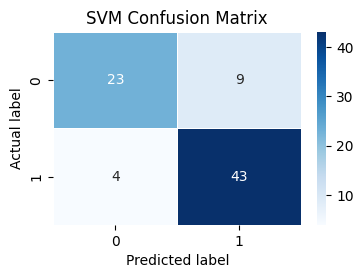

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.726 (± 0.04 )
ROC: 	 	 0.718 (± 0.04 )
AUCPR: 	 	 0.734 (± 0.03 )
Sensitivy: 	 0.755 (± 0.05 )
Specificity: 	 0.682 (± 0.00 )
 


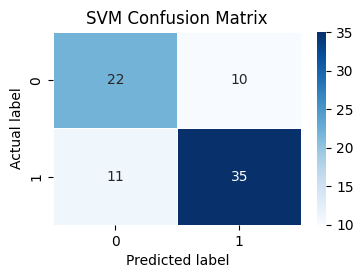

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.909 (± 0.03 )
ROC: 	 	 0.909 (± 0.04 )
AUCPR: 	 	 0.909 (± 0.03 )
Sensitivy: 	 0.906 (± 0.03 )
Specificity: 	 0.912 (± 0.00 )
 


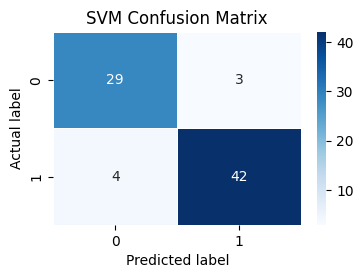

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.863 (± 0.02 )
ROC: 	 	 0.863 (± 0.02 )
AUCPR: 	 	 0.860 (± 0.02 )
Sensitivy: 	 0.867 (± 0.05 )
Specificity: 	 0.858 (± 0.00 )
 


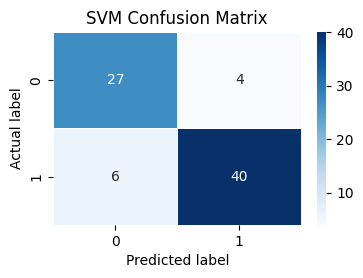

In [35]:
for index, features in enumerate(sets):
    X = data[features]
    y = data[target]

    # Model & pipeline
    svm_model = SVC(kernel='rbf', random_state=123, probability=True)

    svm_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('classifier', svm_model)
    ])

    models.append('SVM')

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores: Confusion Matrix
    y_pred_cv = cross_val_predict(svm_pipeline, X, y, cv=k_fold)
    cm_svm = confusion_matrix(y, y_pred_cv)
    cm_svm = cm_svm / splits
    cm_svm = np.round(cm_svm,0)
    cm_svm = cm_svm.astype(int)
    confusion_matrices.append(cm_svm)

    # Accuracy
    cv_scores_accuracy = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    accuracy.append(mean_cv_accuracy)
    accuracy_sd.append(sd_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    auroc.append(mean_cv_auroc)
    auroc_sd.append(sd_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    aucpr.append(mean_cv_aucpr)
    aucpr_sd.append(sd_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    sensitivity_list.append(mean_cv_sensitivity)
    sensitivity_sd.append(sd_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(svm_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    specificity_list.append(mean_cv_specificity)
    specificity_sd.append(sd_cv_specificity)

    print("++++++++++10-fold CV:++++++++++")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_svm, "SVM Confusion Matrix")

## Random Forest Classifier

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.788 (± 0.04 )
ROC: 	 	 0.773 (± 0.04 )
AUCPR: 	 	 0.773 (± 0.04 )
Sensitivy: 	 0.854 (± 0.09 )
Specificity: 	 0.693 (± 0.00 )
 


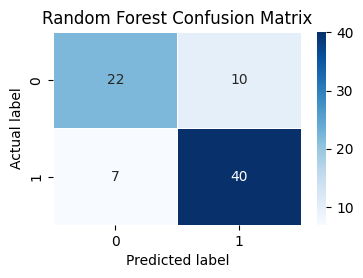

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.700 (± 0.05 )
ROC: 	 	 0.687 (± 0.05 )
AUCPR: 	 	 0.709 (± 0.04 )
Sensitivy: 	 0.752 (± 0.08 )
Specificity: 	 0.622 (± 0.00 )
 


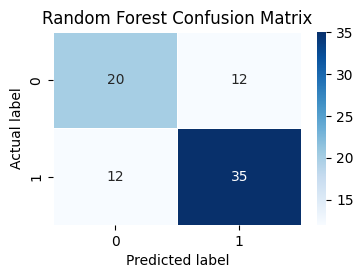

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.940 (± 0.03 )
ROC: 	 	 0.936 (± 0.03 )
AUCPR: 	 	 0.935 (± 0.03 )
Sensitivy: 	 0.946 (± 0.01 )
Specificity: 	 0.927 (± 0.00 )
 


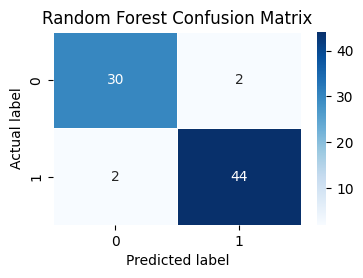

++++++++++10-fold CV:++++++++++
Accuracy: 	 0.936 (± 0.03 )
ROC: 	 	 0.935 (± 0.03 )
AUCPR: 	 	 0.932 (± 0.03 )
Sensitivy: 	 0.941 (± 0.03 )
Specificity: 	 0.929 (± 0.00 )
 


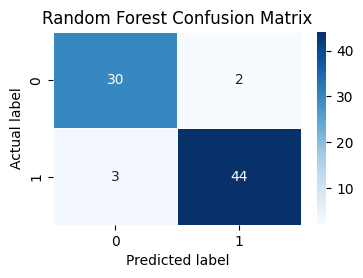

In [36]:
for index, features in enumerate(sets):
    X = data[features]
    y = data[target]

    # Model & pipeline
    rf_model = RandomForestClassifier(n_estimators=100, random_state=123)

    rf_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('classifier', rf_model)
    ])

    models.append('Random Forest')

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores: Confusion Matrix
    y_pred_cv = cross_val_predict(rf_pipeline, X, y, cv=k_fold)
    cm_rf = confusion_matrix(y, y_pred_cv)
    cm_rf = cm_rf / splits
    cm_rf = np.round(cm_rf,0)
    cm_rf = cm_rf.astype(int)
    confusion_matrices.append(cm_rf)

    # Accuracy
    cv_scores_accuracy = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    accuracy.append(mean_cv_accuracy)
    accuracy_sd.append(sd_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    auroc.append(mean_cv_auroc)
    auroc_sd.append(sd_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    aucpr.append(mean_cv_aucpr)
    aucpr_sd.append(sd_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    sensitivity_list.append(mean_cv_sensitivity)
    sensitivity_sd.append(sd_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(rf_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    specificity_list.append(mean_cv_specificity)
    specificity_sd.append(sd_cv_specificity)

    print("++++++++++10-fold CV:++++++++++")
    print("Accuracy: \t", "{:.3f}".format(round(mean_cv_accuracy,3)), "(±", "{:.2f}".format(round(sd_cv_accuracy, 2)), ")")
    print("ROC: \t \t", "{:.3f}".format(round(mean_cv_auroc,3)), "(±", "{:.2f}".format(round(sd_cv_auroc, 2)), ")")
    print("AUCPR: \t \t", "{:.3f}".format(round(mean_cv_aucpr,3)), "(±", "{:.2f}".format(round(sd_cv_aucpr, 2)), ")")
    print("Sensitivy: \t", "{:.3f}".format(round(mean_cv_sensitivity,3)), "(±", "{:.2f}".format(round(sd_cv_sensitivity, 2)), ")")
    print("Specificity: \t", "{:.3f}".format(round(mean_cv_specificity, 3)), "(±", "{:.2f}".format(round(sd_cv_specificity, 2)), ")")
    print(" ")
    plot_confusion_matrix(cm_rf, "Random Forest Confusion Matrix")

## Gradient Boosting Classifier

10-fold CV:
Accuracy: 	 0.819 (± 0.03 )
ROC: 	 	 0.801 (± 0.04 )
AUCPR: 	 	 0.794 (± 0.02 )
Sensitivy: 	 0.905 (± 0.06 )
Specificity: 	 0.696 (± 0.0 )
 


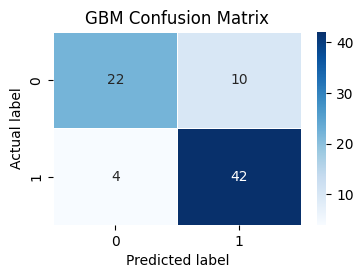

10-fold CV:
Accuracy: 	 0.819 (± 0.03 )
ROC: 	 	 0.801 (± 0.04 )
AUCPR: 	 	 0.794 (± 0.02 )
Sensitivy: 	 0.905 (± 0.06 )
Specificity: 	 0.696 (± 0.0 )
 


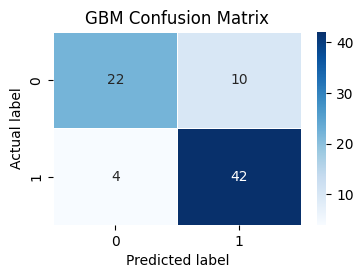

10-fold CV:
Accuracy: 	 0.819 (± 0.03 )
ROC: 	 	 0.801 (± 0.04 )
AUCPR: 	 	 0.794 (± 0.02 )
Sensitivy: 	 0.905 (± 0.06 )
Specificity: 	 0.696 (± 0.0 )
 


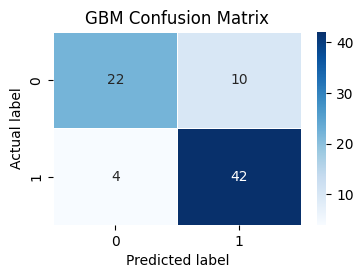

10-fold CV:
Accuracy: 	 0.819 (± 0.03 )
ROC: 	 	 0.801 (± 0.04 )
AUCPR: 	 	 0.794 (± 0.02 )
Sensitivy: 	 0.905 (± 0.06 )
Specificity: 	 0.696 (± 0.0 )
 


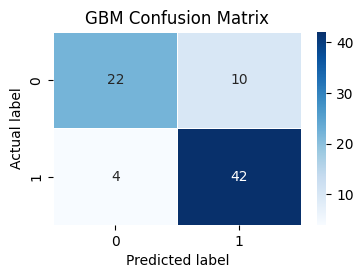

In [37]:
for index, features in enumerate(sets):
    X = data[restricted]
    y = data[target]

    # Model & pipeline
    gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=123)

    gbm_pipeline = Pipeline([
        # ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('classifier', gbm_model)
    ])

    models.append('GBM')

    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)

    # Calculate Scores: Confusion Matrix
    y_pred_cv = cross_val_predict(gbm_pipeline, X, y, cv=k_fold)
    cm_gbm = confusion_matrix(y, y_pred_cv)
    cm_gbm = cm_gbm / splits
    cm_gbm = np.round(cm_gbm,0)
    cm_gbm = cm_gbm.astype(int)
    confusion_matrices.append(cm_gbm)

    # Accuracy
    cv_scores_accuracy = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring="accuracy")
    mean_cv_accuracy = cv_scores_accuracy.mean()
    sd_cv_accuracy = cv_scores_accuracy.std()
    accuracy.append(mean_cv_accuracy)
    accuracy_sd.append(sd_cv_accuracy)

    # ROC
    cv_scores_auroc = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring=auroc_scorer)
    mean_cv_auroc = cv_scores_auroc.mean()
    sd_cv_auroc = cv_scores_auroc.std()
    auroc.append(mean_cv_auroc)
    auroc_sd.append(sd_cv_auroc)

    # AUCPR
    cv_scores_aucpr = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer)
    mean_cv_aucpr = cv_scores_aucpr.mean()
    sd_cv_aucpr = cv_scores_aucpr.std()
    aucpr.append(mean_cv_aucpr)
    aucpr_sd.append(sd_cv_aucpr)

    # Sensitivy
    cv_scores_sensitivity = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring="recall")
    mean_cv_sensitivity = cv_scores_sensitivity.mean()
    sd_cv_sensitivity = cv_scores_sensitivity.std()
    sensitivity_list.append(mean_cv_sensitivity)
    sensitivity_sd.append(sd_cv_sensitivity)

    # Specificity
    cv_scores_specificity = cross_val_score(gbm_pipeline, X, y, cv=k_fold, scoring=specificity_scorer)
    mean_cv_specificity = cv_scores_specificity.mean()
    sd_cv_specificity = mean_cv_specificity.std()
    specificity_list.append(mean_cv_specificity)
    specificity_sd.append(sd_cv_specificity)

    print("10-fold CV:")
    print("Accuracy: \t", round(mean_cv_accuracy,3), "(±", round(sd_cv_accuracy, 2), ")")
    print("ROC: \t \t", round(mean_cv_auroc,3), "(±", round(sd_cv_auroc, 2), ")")
    print("AUCPR: \t \t", round(mean_cv_aucpr,3), "(±", round(sd_cv_aucpr, 2), ")")
    print("Sensitivy: \t", round(mean_cv_sensitivity,3), "(±", round(sd_cv_sensitivity, 2), ")")
    print("Specificity: \t", round(mean_cv_specificity,3), "(±", round(sd_cv_specificity, 2), ")")
    print(" ")
    plot_confusion_matrix(cm_gbm, "GBM Confusion Matrix")

In [38]:
X.shape[1]

5

## Neural Network

In [39]:
from tqdm import tqdm


for index, features in enumerate(sets):
    X = data[restricted]
    y = data[target]

    models.append('Neural Network')

    # Pipeline
    nn_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5))
    ])

    # Using the pipeline for X and creating tensors
    X_nn = nn_pipeline.fit_transform(X)

    X_nn = torch.tensor(X_nn, dtype=torch.float32)
    y_nn = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

    # Model
    class NeuralNetwork(nn.Module):
        def __init__(self, input_dim):
            super(NeuralNetwork, self).__init__()
            self.hidden = nn.Linear(input_dim, 128)
            self.relu = nn.ReLU()
            self.layer2 = nn.Linear(128, 64)
            self.act2 = nn.ReLU()
            self.output = nn.Linear(64, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.hidden(x))
            x = self.act2(self.layer2(x))
            x = self.sigmoid(self.output(x))
            return x

    def model_train(model, X_train, y_train, X_val, y_val):

        # Loss function (binary cross entropy) and optimizer
        loss_func = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        n_epochs = 50
        batch_size = 10
        batch_start = torch.arange(0, len(X_train), batch_size)

        best_acc = -np.inf
        best_weights = None
        best_sensitivity = 0
        best_specificity = 0
        best_auroc = 0
        best_aucpr = 0

        for epoch in range(n_epochs):
            model.train()
            # with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            # for start in tqdm(batch_start, unit="batch", mininterval=0, disable=True):
            with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    # take a batch
                    X_batch = X_train[start:start+batch_size]
                    y_batch = y_train[start:start+batch_size]
                    # forward pass
                    y_pred = model(X_batch)
                    loss = loss_func(y_pred, y_batch)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # print progress
                    acc = (y_pred.round() == y_batch).float().mean()
                    bar.set_postfix(
                        loss=float(loss),
                        acc=float(acc)
                    )
            # evaluate accuracy, sensitivity, specificity, AUROC, and AUCPR at end of each epoch
            model.eval()
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            sensitivity = calculate_sensitivity(y_val, y_pred.round())
            specificity = calculate_specificity(y_val, y_pred.round())
            auroc = auroc_scorer(y_val, y_pred)
            aucpr = aucpr_scorer(y_val, y_pred)

            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
                best_sensitivity = sensitivity
                best_specificity = specificity
                best_auroc = auroc
                best_aucpr = aucpr

        # restore model and return best accuracy, sensitivity, specificity, AUROC, and AUCPR
        model.load_state_dict(best_weights)
        return best_acc, best_auroc, best_aucpr, best_sensitivity, best_specificity

    def calculate_sensitivity(y_true, y_pred):
        true_positive = torch.logical_and(y_true == 1, y_pred == 1).sum().item()
        actual_positive = (y_true == 1).sum().item()
        sensitivity = true_positive / actual_positive if actual_positive != 0 else 0
        return sensitivity

    def calculate_specificity(y_true, y_pred):
        true_negative = torch.logical_and(y_true == 0, y_pred == 0).sum().item()
        actual_negative = (y_true == 0).sum().item()
        specificity = true_negative / actual_negative if actual_negative != 0 else 0
        return specificity

    def auroc_scorer(y_true, y_pred):
        return roc_auc_score(y_true.detach().numpy(), y_pred.detach().numpy())

    def aucpr_scorer(y_true, y_pred):
        return average_precision_score(y_true.detach().numpy(), y_pred.detach().numpy())


    # 10 fold CV
    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)
    cv_scores_accuracy = []
    cv_scores_auroc = []
    cv_scores_aucpr = []
    cv_scores_sensitivity = []
    cv_scores_specificity = []

    for train_index, test_index in k_fold.split(X_nn):
        model = NeuralNetwork(X_nn.shape[1])  # Initialize model with the correct input dimension
        results = model_train(model, X_nn[train_index], y_nn[train_index], X_nn[test_index], y_nn[test_index])
        cv_scores_accuracy.append(results[0])
        cv_scores_auroc.append(results[1])
        cv_scores_aucpr.append(results[2])
        cv_scores_sensitivity.append(results[3])
        cv_scores_specificity.append(results[4])


    accuracy.append(np.mean(cv_scores_accuracy))
    accuracy_sd.append(np.std(cv_scores_accuracy))

    auroc.append(np.mean(cv_scores_auroc))
    auroc_sd.append(np.std(cv_scores_auroc))

    aucpr.append(np.mean(cv_scores_aucpr))
    aucpr_sd.append(np.std(cv_scores_aucpr))

    sensitivity_list.append(np.mean(cv_scores_sensitivity))
    sensitivity_sd.append(np.std(cv_scores_sensitivity))

    specificity_list.append(np.mean(cv_scores_specificity))
    specificity_sd.append(np.std(cv_scores_specificity))

    print("10-fold CV:")
    print("Accuracy: \t", round(np.mean(cv_scores_accuracy),3), "(±", round(np.std(cv_scores_accuracy), 2), ")")
    print("ROC: \t \t", round(np.mean(cv_scores_auroc), 3), "(±", round(np.std(cv_scores_auroc), 2), ")")
    print("AUCPR: \t \t", round(np.mean(cv_scores_aucpr), 3), "(±", round(np.std(cv_scores_aucpr), 2), ")")
    print("Sensitivity: \t", round(np.mean(cv_scores_sensitivity), 3), "(±", round(np.std(cv_scores_sensitivity), 2), ")")
    print("Specificity: \t", round(np.mean(cv_scores_specificity), 3), "(±", round(np.std(cv_scores_specificity), 2), ")")
    print(" ")

10-fold CV:
Accuracy: 	 0.84 (± 0.03 )
ROC: 	 	 0.886 (± 0.03 )
AUCPR: 	 	 0.912 (± 0.02 )
Sensitivity: 	 0.908 (± 0.03 )
Specificity: 	 0.741 (± 0.08 )
 
10-fold CV:
Accuracy: 	 0.84 (± 0.04 )
ROC: 	 	 0.88 (± 0.03 )
AUCPR: 	 	 0.907 (± 0.03 )
Sensitivity: 	 0.892 (± 0.07 )
Specificity: 	 0.762 (± 0.09 )
 
10-fold CV:
Accuracy: 	 0.838 (± 0.03 )
ROC: 	 	 0.889 (± 0.03 )
AUCPR: 	 	 0.914 (± 0.03 )
Sensitivity: 	 0.897 (± 0.05 )
Specificity: 	 0.754 (± 0.05 )
 
10-fold CV:
Accuracy: 	 0.844 (± 0.03 )
ROC: 	 	 0.882 (± 0.03 )
AUCPR: 	 	 0.909 (± 0.03 )
Sensitivity: 	 0.91 (± 0.03 )
Specificity: 	 0.748 (± 0.06 )
 


## Summary & Model Comparison

                  Model    Metric     Value
0   Logistic Regression  Accuracy  0.826923
1   Logistic Regression  Accuracy  0.732051
2   Logistic Regression  Accuracy  0.884615
3   Logistic Regression  Accuracy  0.874359
4           Naive Bayes  Accuracy  0.789744
..                  ...       ...       ...
67                  GBM     AUCPR  0.793687
68       Neural Network     AUCPR  0.912429
69       Neural Network     AUCPR  0.907134
70       Neural Network     AUCPR  0.914461
71       Neural Network     AUCPR  0.909011

[72 rows x 3 columns]


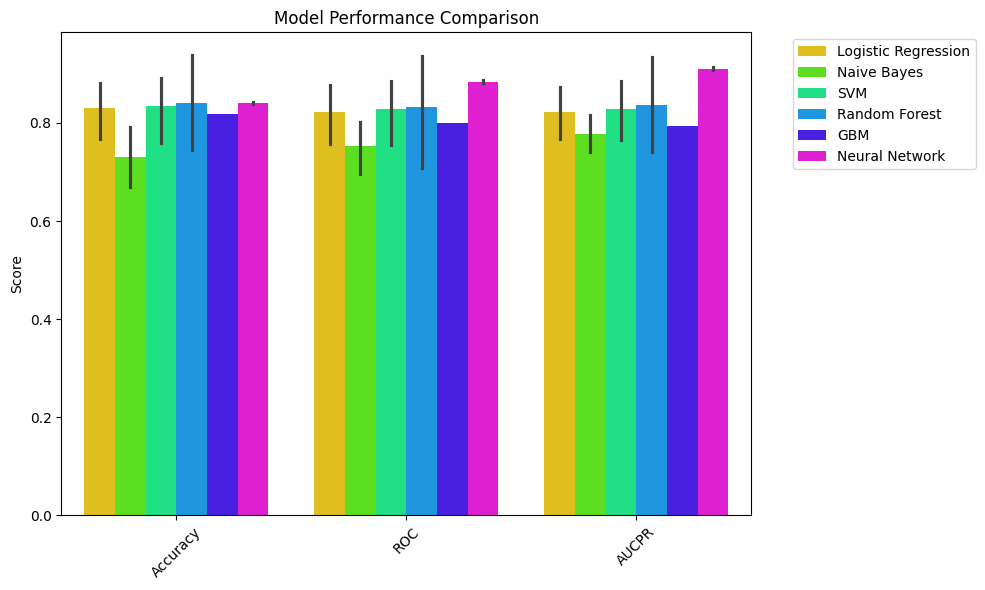

In [42]:
# Define a color palette
colors = sns.color_palette("hsv", len(metrics_melted['Model'].unique()))  # Matches the number of unique models

metrics = ["Accuracy", "ROC", "AUCPR"]
values = [accuracy, auroc, aucpr]

data = {"Model": models}
for metric, metric_values in zip(metrics, values):
    if len(metric_values) != len(models):
        print(f"Error: Length of values for {metric} ({len(metric_values)}) does not match number of models ({len(models)}).")
    data[metric] = metric_values

try:
    metrics_df = pd.DataFrame(data)
except ValueError as e:
    print("Failed to create DataFrame:", e)

try:
    metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")
    print(metrics_melted)
except Exception as e:
    print("Failed to melt DataFrame:", e)

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Model", palette=colors)
plt.title("Model Performance Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

                  Model       Metric     Value
0   Logistic Regression  Sensitivity  0.880016
1   Logistic Regression  Sensitivity  0.770802
2   Logistic Regression  Sensitivity  0.883561
3   Logistic Regression  Sensitivity  0.889313
4           Naive Bayes  Sensitivity  0.754125
5           Naive Bayes  Sensitivity  0.635340
6           Naive Bayes  Sensitivity  0.728567
7           Naive Bayes  Sensitivity  0.410059
8                   SVM  Sensitivity  0.925215
9                   SVM  Sensitivity  0.754539
10                  SVM  Sensitivity  0.906166
11                  SVM  Sensitivity  0.867343
12        Random Forest  Sensitivity  0.853937
13        Random Forest  Sensitivity  0.752487
14        Random Forest  Sensitivity  0.946157
15        Random Forest  Sensitivity  0.940560
16                  GBM  Sensitivity  0.905227
17                  GBM  Sensitivity  0.905227
18                  GBM  Sensitivity  0.905227
19                  GBM  Sensitivity  0.905227
20       Neur

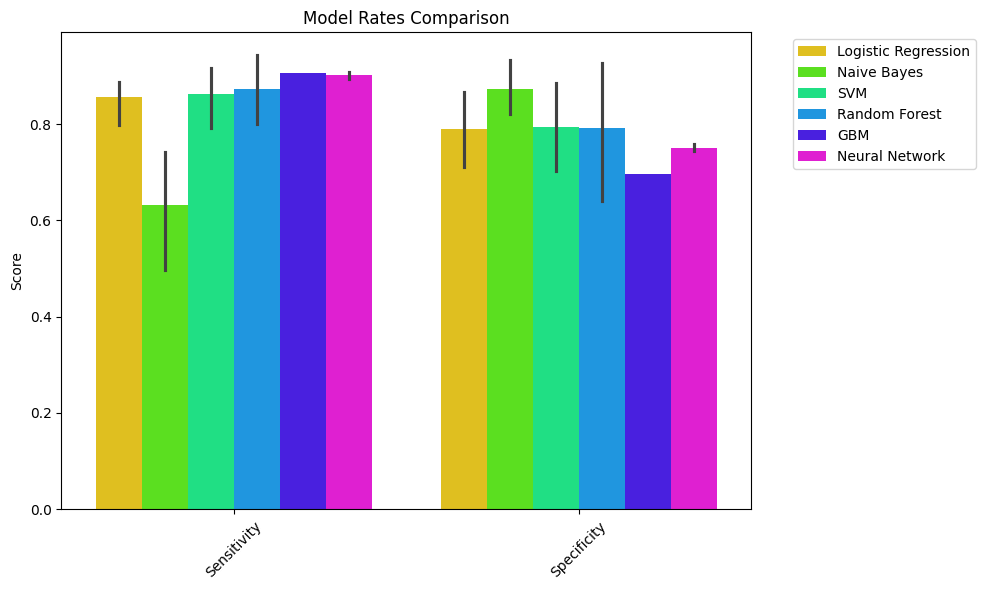

In [43]:
metrics = ["Sensitivity", "Specificity"]
values = [sensitivity_list, specificity_list]

data = {"Model": models}
for metric, metric_values in zip(metrics, values):
    if len(metric_values) != len(models):
        print(f"Error: Length of values for {metric} ({len(metric_values)}) does not match number of models ({len(models)}).")
    data[metric] = metric_values

try:
    metrics_df = pd.DataFrame(data)
except ValueError as e:
    print("Failed to create DataFrame:", e)

try:
    metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")
    print(metrics_melted)
except Exception as e:
    print("Failed to melt DataFrame:", e)

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Model", palette=colors)
plt.title("Model Rates Comparison")
plt.xlabel("")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()